### Routine per il fine tuning del modello 

In [16]:
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import (
    RandomizedSearchCV, GridSearchCV, StratifiedKFold, 
    train_test_split, cross_val_score
)
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, classification_report, confusion_matrix
)
from sklearn.preprocessing import StandardScaler, LabelEncoder
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')


In [ ]:
# Leggi i dati e le etichette dai file Parquet nella cartella preprocessed/binary/data_w_features
features_df_full = pd.read_parquet('processed_data/binary_classification/data_w_features/combined_features.parquet')
labels_df_full = pd.read_parquet('processed_data/binary_classification/data_w_features/labels_binary_stats_features_only.parquet')

# Campiona 10000 righe con distribuzione bilanciata tra le classi di labels_df per il training
n_samples_per_class = 100000  # 10000/2 per due classi
sampled_indices = (
    labels_df_full.groupby(labels_df_full.iloc[:, 0])
    .apply(lambda x: x.sample(n=n_samples_per_class, random_state=42))
    .index.get_level_values(1)
)
features_df = features_df_full.loc[sampled_indices].reset_index(drop=True)
labels_df = labels_df_full.loc[sampled_indices].reset_index(drop=True)

# Campiona 500000 righe con distribuzione bilanciata tra le classi di labels_df per il fit finale
n_samples_per_class = 250000  # 10000/2 per due classi
sampled_indices = (
    labels_df_full.groupby(labels_df_full.iloc[:, 0])
    .apply(lambda x: x.sample(n=n_samples_per_class, random_state=42))
    .index.get_level_values(1)
)
features_df_to_finalize = features_df_full.loc[sampled_indices].reset_index(drop=True)
labels_df_to_finalize = labels_df_full.loc[sampled_indices].reset_index(drop=True)

del features_df_full, labels_df_full, sampled_indices



In [18]:
features_df

,mean,std,min,max,median,range,skew,kurtosis,entropy,gini,...,q3_center_gini_diff,q4_center_gini_diff,q1_center_skew_diff,q2_center_skew_diff,q3_center_skew_diff,q4_center_skew_diff,q1_center_kurtosis_diff,q2_center_kurtosis_diff,q3_center_kurtosis_diff,q4_center_kurtosis_diff
0,8.566654e+07,5.405539e+07,59536580.0,416871392.0,67670792.0,357334812.0,3.730565,15.329312,5.167182,0.216282,...,-0.026047,-0.133589,1.841833,1.605214,1.540579,1.878239,10.581544,8.599468,7.974024,10.467315
1,8.171002e+07,4.591487e+07,47410760.0,287954432.0,62261370.0,240543672.0,2.434622,5.640444,5.178125,0.239258,...,-0.004875,-0.103299,1.223027,1.044336,1.508792,1.900401,3.966247,3.352778,5.288776,7.677078
2,7.507116e+07,2.601376e+07,49175624.0,181784224.0,65768858.0,132608600.0,2.131402,4.244071,5.247741,0.158986,...,-0.104453,-0.149493,0.891815,0.326131,1.363395,0.201802,2.559904,0.497681,5.191670,2.297534
3,1.118472e+08,7.551935e+07,61199648.0,408370272.0,74323884.0,347170624.0,2.016131,3.372534,5.121701,0.302952,...,0.084786,0.050894,1.095314,0.951806,0.551743,1.043705,3.255406,2.672049,1.280910,2.915222
4,1.060989e+08,5.057546e+07,64051448.0,308598464.0,85365000.0,244547016.0,2.184273,4.356320,5.207119,0.215164,...,-0.036485,-0.107657,1.224033,0.927812,1.558989,1.598185,3.509050,2.247522,4.829135,5.564647
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39995,1.071886e+08,1.006194e+08,52327984.0,680239360.0,69238588.0,627911376.0,3.258092,11.644201,5.021017,0.351108,...,0.013135,-0.123923,1.592794,1.348821,1.578330,1.703337,7.603449,6.023091,7.443054,8.047777
39996,8.025496e+07,2.575271e+07,48246740.0,173786336.0,73235508.0,125539596.0,1.326730,1.734362,5.251294,0.170106,...,-0.038435,-0.090070,0.486465,0.947934,2.002482,1.661689,0.765859,2.190569,6.073720,4.730400
39997,9.595742e+07,4.804887e+07,48418128.0,279372544.0,78864240.0,230954416.0,1.773487,2.749153,5.193345,0.245582,...,0.061571,-0.012525,0.773081,0.771732,1.398100,1.938965,1.726507,1.688765,3.768261,6.539993
39998,8.244184e+07,2.715903e+07,51975824.0,213830400.0,74554532.0,161854576.0,2.640400,7.520032,5.253779,0.144910,...,0.001549,-0.050321,0.246802,0.906904,0.998606,1.295360,1.392308,3.928331,3.752066,5.608095


In [19]:
len(features_df), len(labels_df)

(40000, 40000)

In [20]:
from collections import Counter
Counter(labels_df.iloc[:, 0])

Counter({0: 20000, 1: 20000})

In [ ]:

class XGBoostTrainer:
    """
    Classe per addestrare un XGBoost classifier con ricerca approfondita degli iperparametri
    """
    
    def __init__(self, random_state=42, n_jobs=-1):
        """
        Inizializza il trainer
        
        Parameters:
        -----------
        random_state : int
            Seed per la riproducibilità
        n_jobs : int
            Numero di core da utilizzare (-1 per tutti)
        """
        self.random_state = random_state
        self.n_jobs = n_jobs
        self.model = None
        self.best_model = None
        self.scaler = StandardScaler()
        self.label_encoder = LabelEncoder()
        self.search_results = None
        self.feature_importance = None
        
    def prepare_data(self, features_df, labels_df, test_size=0.2, scale=True):
        
        
        # Converti labels in array se necessario
        if isinstance(labels_df, pd.DataFrame):
            y = labels_df.values.ravel()
        else:
            y = labels_df.values
            
        # Split
        X_train, X_test, y_train, y_test = train_test_split(
            features_df, y, test_size=test_size, 
            random_state=self.random_state, stratify=y)
        
        # Scaling 
        if scale:
            X_train = self.scaler.fit_transform(X_train)
            X_test = self.scaler.transform(X_test)
            
        return X_train, X_test, y_train, y_test
    
    def get_param_grid(self, search_type='extensive'):
        
        if search_type == 'quick':
            param_grid = {
                'n_estimators': [100, 200],
                'max_depth': [3, 5, 7],
                'learning_rate': [0.01, 0.1],
                'subsample': [0.8, 1.0],
                'colsample_bytree': [0.8, 1.0]
            }
        elif search_type == 'standard':
            param_grid = {
                'n_estimators': [100, 200, 300],
                'max_depth': [3, 5, 7, 10],
                'learning_rate': [0.01, 0.05, 0.1, 0.3],
                'subsample': [0.6, 0.8, 1.0],
                'colsample_bytree': [0.6, 0.8, 1.0],
                'gamma': [0, 0.1, 0.3],
                'reg_alpha': [0, 0.01, 0.1],
                'reg_lambda': [0, 0.01, 0.1]
            }
        else:  # extensive
            param_grid = {
                'n_estimators': [100, 200, 300, 500, 1000],
                'max_depth': [3, 5, 7, 10, 15, 20],
                'learning_rate': [0.001, 0.003, 0.005, 0.007, 0.009, 0.01, 0.05, 0.1],
                'subsample': [0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
                'colsample_bytree': [0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
                'colsample_bylevel': [0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
                'gamma': [0, 0.01, 0.05, 0.1, 0.3, 0.5],
                'reg_alpha': [0, 0.001, 0.01, 0.1, 0.5, 1.0],
                'reg_lambda': [0, 0.001, 0.01, 0.1, 0.5, 1.0],
                'min_child_weight': [1, 3, 5, 7, 10],
                'scale_pos_weight': [1, 2, 3, 5]  # utile per dataset sbilanciati
            }
            
        return param_grid
    
    def search_hyperparameters(self, X_train, y_train, search_type='extensive', 
                             search_method='random', n_iter=100, cv_folds=5):
        
        print(f"Inizio ricerca iperparametri ({search_method} search, {search_type})...")
        
        # Modello base
        base_model = xgb.XGBClassifier(
            objective='binary:logistic' if len(np.unique(y_train)) == 2 else 'multi:softprob',
            random_state=self.random_state,
            n_jobs=self.n_jobs,
            use_label_encoder=False,
            eval_metric='logloss'
        )
        
        param_grid = self.get_param_grid(search_type)
        
        cv = StratifiedKFold(n_splits=cv_folds, shuffle=True, random_state=self.random_state)
        
        if search_method == 'grid':
            search = GridSearchCV(
                estimator=base_model,
                param_grid=param_grid,
                cv=cv,
                scoring='roc_auc' if len(np.unique(y_train)) == 2 else 'accuracy',
                n_jobs=self.n_jobs,
                verbose=1
            )
        else:  # random
            search = RandomizedSearchCV(
                estimator=base_model,
                param_distributions=param_grid,
                n_iter=n_iter,
                cv=cv,
                scoring='roc_auc' if len(np.unique(y_train)) == 2 else 'accuracy',
                n_jobs=self.n_jobs,
                verbose=1,
                random_state=self.random_state
            )
        
        # Esegui la ricerca
        search.fit(X_train, y_train)
        
        self.search_results = search
        self.best_model = search.best_estimator_
        
        for param, value in search.best_params_.items():
            print(f"  {param}: {value}")
        print(f"\nMiglior score CV: {search.best_score_:.4f}")
        
        return search.best_params_
    
    def train_final_model(self, X_train, y_train, params=None):
        
        if params is None and self.search_results is not None:
            params = self.search_results.best_params_
        elif params is None:
            params = {}
            
        print("Addestramento modello finale usando gli iperparametri trovati...")
        
        self.model = xgb.XGBClassifier(
            objective='binary:logistic' if len(np.unique(y_train)) == 2 else 'multi:softprob',
            random_state=self.random_state,
            n_jobs=self.n_jobs,
            use_label_encoder=False,
            eval_metric='logloss',
            **params
        )
        
        self.model.fit(X_train, y_train)
        
        # Feature importance
        self.feature_importance = pd.DataFrame({
            'feature': range(X_train.shape[1]),
            'importance': self.model.feature_importances_
        }).sort_values('importance', ascending=False)
        
        print("Modello addestrato con successo!")
        
    def evaluate_model(self, X_test, y_test, show_plots=True):
        
        if self.model is None:
            raise ValueError("Il modello non è stato ancora addestrato!")
            
        y_pred = self.model.predict(X_test)
        
        # Metriche
        metrics = {
            'accuracy': accuracy_score(y_test, y_pred),
            'precision': precision_score(y_test, y_pred, average='weighted'),
            'recall': recall_score(y_test, y_pred, average='weighted'),
            'f1': f1_score(y_test, y_pred, average='weighted')
        }
        
        # AUC
        if len(np.unique(y_test)) == 2:
            y_proba = self.model.predict_proba(X_test)[:, 1]
            metrics['roc_auc'] = roc_auc_score(y_test, y_proba)
            
        print("\nMetriche di valutazione:")
        for metric, value in metrics.items():
            print(f"  {metric}: {value:.4f}")
            
        print("\nClassification Report:")
        print(classification_report(y_test, y_pred))
        
        if show_plots:
            self._plot_results(y_test, y_pred)
            
        return metrics
    
    def _plot_results(self, y_test, y_pred):
        """
        Visualizza i risultati
        """
        fig, axes = plt.subplots(1, 2, figsize=(15, 5))
        
        # Confusion Matrix
        cm = confusion_matrix(y_test, y_pred)
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0])
        axes[0].set_title('Confusion Matrix')
        axes[0].set_xlabel('Predicted')
        axes[0].set_ylabel('Actual')
        
        # Feature Importance (top 20)
        if self.feature_importance is not None:
            top_features = self.feature_importance.head(20)
            axes[1].barh(top_features['feature'].astype(str), top_features['importance'])
            axes[1].set_xlabel('Importance')
            axes[1].set_ylabel('Feature')
            axes[1].set_title('Top 20 Feature Importance')
            axes[1].invert_yaxis()
            
        plt.tight_layout()
        plt.show()
    
    def cross_validate(self, X, y, cv_folds=5):
        
        if self.model is None:
            raise ValueError("Il modello non è stato ancora addestrato!")
            
        cv = StratifiedKFold(n_splits=cv_folds, shuffle=True, random_state=self.random_state)
        scores = cross_val_score(
            self.model, X, y, cv=cv, 
            scoring='roc_auc' if len(np.unique(y)) == 2 else 'accuracy'
        )
        
        print(f"\nCross-validation scores: {scores}")
        print(f"Mean CV score: {scores.mean():.4f} (+/- {scores.std() * 2:.4f})")
        
        return scores
    
    def save_model(self, filepath):
        
        if self.model is None:
            raise ValueError("Il modello non è stato ancora addestrato!")
            
        model_data = {
            'model': self.model,
            'scaler': self.scaler,
            'label_encoder': self.label_encoder,
            'feature_importance': self.feature_importance,
            'best_params': self.search_results.best_params_ if self.search_results else None,
            'timestamp': datetime.now().isoformat()
        }
        
        joblib.dump(model_data, filepath)
        print(f"Modello salvato in: {filepath}")
        
    def load_model(self, filepath):
        
        model_data = joblib.load(filepath)
        
        self.model = model_data['model']
        self.scaler = model_data['scaler']
        self.label_encoder = model_data['label_encoder']
        self.feature_importance = model_data['feature_importance']
        
        print(f"Modello caricato da: {filepath}")
        print(f"Salvato il: {model_data['timestamp']}")
        
    def predict(self, X):
        
        if self.model is None:
            raise ValueError("Il modello non è stato ancora addestrato!")
            
        # Scala i dati se necessario
        if hasattr(self.scaler, 'mean_'):
            X = self.scaler.transform(X)
            
        predictions = self.model.predict(X)
        
        # Decodifica le labels se necessario
        if hasattr(self.label_encoder, 'classes_'):
            predictions = self.label_encoder.inverse_transform(predictions)
            
        return predictions
    
    def predict_proba(self, X):
        
        if self.model is None:
            raise ValueError("Il modello non è stato ancora addestrato!")
            
        # Scala i dati se necessario
        if hasattr(self.scaler, 'mean_'):
            X = self.scaler.transform(X)
            
        return self.model.predict_proba(X)

Inizio ricerca iperparametri (random search, extensive)...
Fitting 5 folds for each of 200 candidates, totalling 1000 fits
  subsample: 0.7
  scale_pos_weight: 3
  reg_lambda: 1.0
  reg_alpha: 0.01
  n_estimators: 1000
  min_child_weight: 7
  max_depth: 20
  learning_rate: 0.01
  gamma: 0.1
  colsample_bytree: 0.9
  colsample_bylevel: 0.9

Miglior score CV: 0.9138
Addestramento modello finale...
Modello addestrato con successo!

Metriche di valutazione:
  accuracy: 0.8224
  precision: 0.8343
  recall: 0.8224
  f1: 0.8208
  roc_auc: 0.9119

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.73      0.80      4000
           1       0.77      0.92      0.84      4000

    accuracy                           0.82      8000
   macro avg       0.83      0.82      0.82      8000
weighted avg       0.83      0.82      0.82      8000



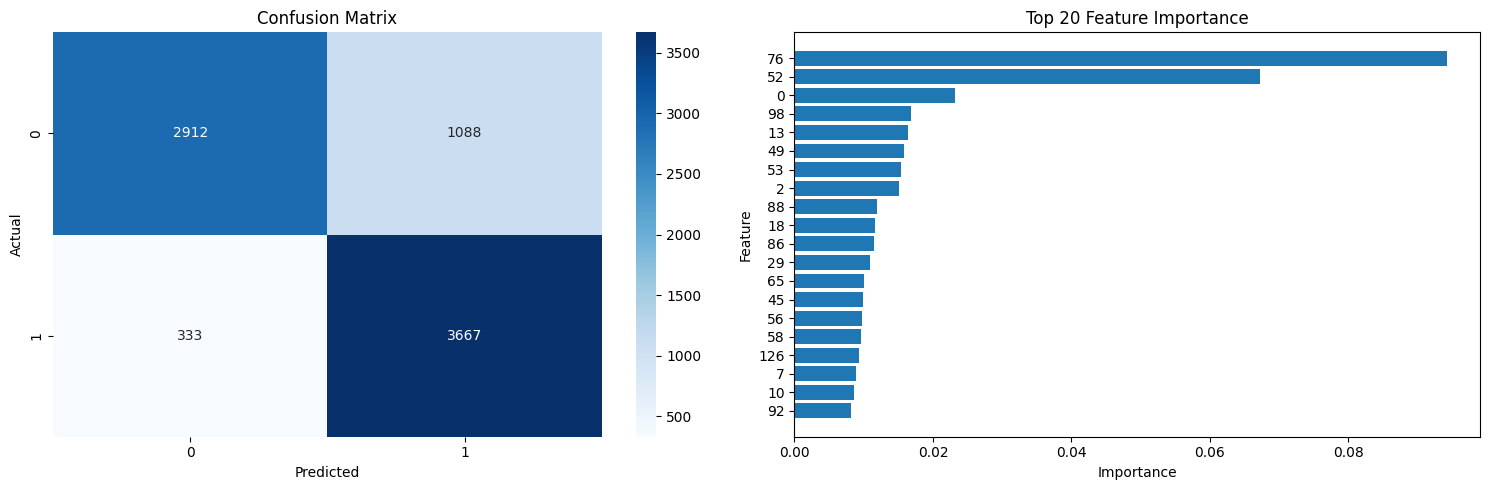


Cross-validation scores: [0.91985913 0.91488076 0.91124009 0.91428037 0.90960112]
Mean CV score: 0.9140 (+/- 0.0071)
Modello salvato in: xgboost_model.pkl


In [ ]:

#Training 
if __name__ == "__main__":
    
    trainer = XGBoostTrainer(random_state=42)
    
    X_train, X_test, y_train, y_test = trainer.prepare_data(features_df, labels_df, scale=True)
    
    best_params = trainer.search_hyperparameters(
         X_train, y_train, 
         search_type='extensive',
         search_method='random',
         n_iter=200
     )
    trainer.train_final_model(X_train, y_train)

    metrics = trainer.evaluate_model(X_test, y_test)

    cv_scores = trainer.cross_validate(X_train, y_train)

    trainer.save_model('xgboost_model.pkl')

In [23]:
# Salva il modello addestrato
# Addestra il modello XGBoost finale sui dati completi con i migliori iperparametri trovati
X_full = trainer.scaler.fit_transform(features_df_to_finalize)
if isinstance(labels_df_to_finalize, pd.DataFrame):
    y_full = labels_df_to_finalize.values.ravel()
else:
    y_full = labels_df_to_finalize.values

trainer.train_final_model(X_full, y_full, params=trainer.search_results.best_params_)
trainer.save_model('xgboost_model_final.pkl')

Addestramento modello finale...
Modello addestrato con successo!
Modello salvato in: xgboost_model_final.pkl
